# Monte Carlo sample size experiment
this file imports the Monte Carlo samples (and maybe simulation results) for all of the provinces and looks at percent difference between samples sizes to determine an adequate sample size for results.

In [1]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import geopandas as gpd
import random

import re
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# My funcs and classes

sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Import data

In [2]:
prov = ['nl','ns','nb','pei','qc','on','mb','sk','ab','bc','nwt','yk']

p_samples = {}
for p in prov:
    p_samples[p] = pd.read_csv('C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'+p+'/inf_mc_samples_'+p+'.csv')

In [4]:
p_samples['bc']

,DAUID,house_ghg_pp,road_ghg_pp,water_inf_ghg_pp
0,59010124,24319.512810,4259.333280,263.946481
1,59410324,21983.383804,3871.390485,633.776288
2,59153765,14786.368072,11695.777350,472.849984
3,59090639,13815.678760,15314.261949,372.191460
4,59151319,14507.569477,709.979093,168.269091
...,...,...,...,...
3685995,59154374,18824.877442,730.434413,228.067403
3685996,59154375,17302.912115,603.546584,236.335686
3685997,59154376,14621.208828,800.751903,160.683578
3685998,59170036,18501.783732,958.726614,126.110582


## Modify
order the data to make it easy to perform experiment at many sample sizes.

In [5]:
def iter_add(samp, n_iters=500):
    """
    organize the province samples, add an iter column.
    samp = sample
    n_iters = number of iterations in the sample
    """
    samp = samp.sort_values('DAUID')
    samp['iter'] = np.tile(np.arange(0,n_iters), samp['DAUID'].unique().size)
    return samp

Take the average percent change in the mean, median, and standard deviation

In [62]:
s = 10
averager = np.mean

p_all = pd.DataFrame(columns=p_samples['bc'].groupby('DAUID').mean().columns)
for p in p_samples:
    p_ia = iter_add(p_samples[p])
    p_ia = p_ia[p_ia['iter'] < s]
    p_ia_avg = p_ia.groupby('DAUID').agg(averager)
    
    p_all = pd.concat([p_all, p_ia_avg])

In [67]:
#iter_add(p_samples[p]).groupby('DAUID').agg(np.mean)
p_all.drop('iter', axis=1)

,house_ghg_pp,road_ghg_pp,water_inf_ghg_pp
10010165,21777.553524,1776.160732,375.496798
10010166,22754.983855,1075.778116,266.234679
10010167,22136.369114,1060.527298,209.763988
10010168,23664.572619,1126.521632,289.210662
10010169,20736.13767,890.496617,208.986937
...,...,...,...
60010292,26081.492973,11778.787815,1179.095997
60010295,32213.737413,481414.166608,991.618909
60010301,29415.509066,2244.483243,457.438299
60010302,27680.475178,6332.566072,110.485933


Create function that repeats above process for multiple sample sizes and stores

In [68]:
def monte_carlo_sumstat_agg(p_samples, iters, averager=np.mean):
    p_all = pd.DataFrame(columns=p_samples['bc'].groupby('DAUID').mean().columns)
    for p in p_samples:
        p_ia = iter_add(p_samples[p])
        p_ia = p_ia[p_ia['iter'] < iters]
        p_ia_avg = p_ia.groupby('DAUID').agg(averager)
        
        p_all = pd.concat([p_all, p_ia_avg])
    
    return p_all.drop('iter', axis=1)

In [78]:
#sizes = [100, 200, 300, 400, 500]
sizes = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

sample_size_exp = {}
for s in sizes:
    print('size: ', s)
    sample_size_exp[s] = monte_carlo_sumstat_agg(p_samples, s)


size:  50
size:  100
size:  150
size:  200
size:  250
size:  300
size:  350
size:  400
size:  450
size:  500


In [150]:
#sizes = [100, 200, 300, 400, 500]
sizes = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

sample_size_exp_robust = {}
for s in sizes:
    print('size: ', s)
    sample_size_exp_robust[s] = monte_carlo_sumstat_agg(p_samples, s, averager=np.median)


size:  50
size:  100
size:  150
size:  200
size:  250
size:  300
size:  350
size:  400
size:  450
size:  500


In [94]:
sample_size_exp[450].mean() #(sample_size_exp[450]['house_ghg_pp'].mean() - sample_size_exp[400]['house_ghg_pp'].mean())/sample_size_exp[400]['house_ghg_pp'].mean()

house_ghg_pp        20730.024642
road_ghg_pp          4607.137686
water_inf_ghg_pp      355.719972
dtype: float64

## Plot
plot average percent difference

In [151]:
# take 1 step ahead for each summary statistic in all of Canada
current_mean = [sample_size_exp[sizes[i]].mean() for i in range(1,10)]
previous_mean = [sample_size_exp[sizes[i]].mean() for i in range(0,9)]

current_median = [sample_size_exp[sizes[i]].median() for i in range(1,10)]
previous_median = [sample_size_exp[sizes[i]].median() for i in range(0,9)]

current_std = [sample_size_exp[sizes[i]].std() for i in range(1,10)]
previous_std = [sample_size_exp[sizes[i]].std() for i in range(0,9)]

# subtact difference for each
dff_mean = [np.abs((current_mean[i] - previous_mean[i])/previous_mean[0])*100 for i in range(0,9)]
dff_median = [np.abs((current_median[i] - previous_median[i])/previous_median[0])*100 for i in range(0,9)]
dff_std = [np.abs((current_std[i] - previous_std[i])/previous_std[0])*100 for i in range(0,9)]


## REPEAT FOR ROBUST
# take 1 step ahead for each summary statistic in all of Canada
current_mean_r = [sample_size_exp_robust[sizes[i]].mean() for i in range(1,10)]
previous_mean_r = [sample_size_exp_robust[sizes[i]].mean() for i in range(0,9)]

current_median_r = [sample_size_exp_robust[sizes[i]].median() for i in range(1,10)]
previous_median_r = [sample_size_exp_robust[sizes[i]].median() for i in range(0,9)]

current_std_r = [sample_size_exp_robust[sizes[i]].std() for i in range(1,10)]
previous_std_r = [sample_size_exp_robust[sizes[i]].std() for i in range(0,9)]

# subtact difference for each
dff_mean_r = [np.abs((current_mean_r[i] - previous_mean_r[i])/previous_mean_r[0])*100 for i in range(0,9)]
dff_median_r = [np.abs((current_median_r[i] - previous_median_r[i])/previous_median_r[0])*100 for i in range(0,9)]
dff_std_r = [np.abs((current_std_r[i] - previous_std_r[i])/previous_std_r[0])*100 for i in range(0,9)]

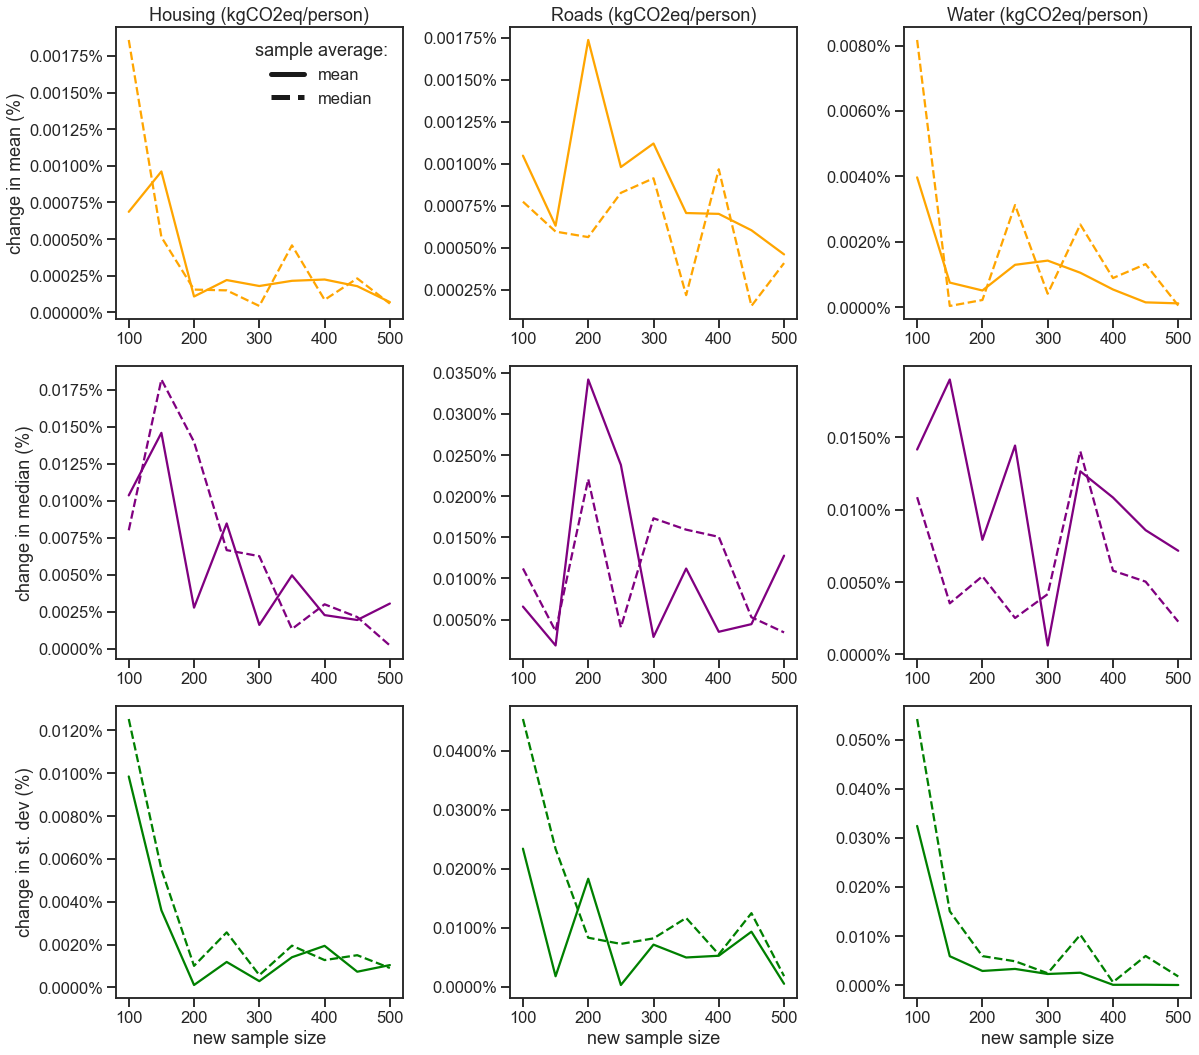

In [168]:
# now plot for each stat for each infrastructure type
import matplotlib.ticker as mtick
fig, ax = plt.subplots(3,3, figsize=(17,15))
i_type = ['house_ghg_pp','road_ghg_pp','water_inf_ghg_pp']
colors = ['orange','purple','green']

for j in range(3):
    sns.lineplot(ax=ax[0,j], x=sizes[1:], y=[dff_mean[i][i_type[j]] for i in range (0,9)], color=colors[0])
    ax[0,j].yaxis.set_major_formatter(mtick.PercentFormatter())
    sns.lineplot(ax=ax[0,j], x=sizes[1:], y=[dff_mean_r[i][i_type[j]] for i in range (0,9)], color=colors[0], linestyle='--')

for j in range(3):
    sns.lineplot(ax=ax[1,j], x=sizes[1:], y=[dff_median[i][i_type[j]] for i in range (0,9)], color=colors[1])
    sns.lineplot(ax=ax[1,j], x=sizes[1:], y=[dff_median_r[i][i_type[j]] for i in range (0,9)], color=colors[1], linestyle='--')
    ax[1,j].yaxis.set_major_formatter(mtick.PercentFormatter())

for j in range(3):
    sns.lineplot(ax=ax[2,j], x=sizes[1:], y=[dff_std[i][i_type[j]] for i in range (0,9)], color=colors[2])
    sns.lineplot(ax=ax[2,j], x=sizes[1:], y=[dff_std_r[i][i_type[j]] for i in range (0,9)], color=colors[2], linestyle='--')
    ax[2,j].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[2,j].set_xlabel('new sample size')

# ax options
ax[0,0].set_ylabel('change in mean (%)')
ax[1,0].set_ylabel('change in median (%)')
ax[2,0].set_ylabel('change in st. dev (%)')

ax[0,0].set_title('Housing (kgCO2eq/person)')
ax[0,1].set_title('Roads (kgCO2eq/person)')
ax[0,2].set_title('Water (kgCO2eq/person)')


# legend
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='k', lw=5, linestyle='solid'),
    Line2D([0], [0], color='k', lw=5, linestyle='dashed'),
                ]

ax[0,0].legend(custom_lines, ['mean','median'], title='sample average:', frameon=False)


plt.tight_layout()
#plt.savefig('mc_samp_experiment.png', bbox_inches='tight', dpi=600)

In [124]:
[dff_mean[i]['house_ghg_pp'] for i in range (0,9)]

[0.0006862354795215325,
 0.0009616041640109062,
 0.00010818072257026585,
 0.00022046125048826287,
 0.0001797796688714249,
 0.00021531877430999642,
 0.00022418779160695673,
 0.000178666264093161,
 6.998703071267183e-05]

In [117]:
np.abs((current_mean[0] - previous_mean[0])/previous_mean[0])*100
#previous_mean[0]

house_ghg_pp        0.000686
road_ghg_pp         0.001047
water_inf_ghg_pp    0.003969
dtype: float64